In [1201]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [1202]:
data = pd.read_csv('../data/multistep_regression.csv')
data.head()

,Year,Month,Value
0,1999,1,40.575599
1,1999,2,65.182165
2,1999,3,63.089448
3,1999,4,81.853452
4,1999,5,48.081737


In [1203]:
data.describe()

,Year,Month,Value
count,281.000000,281.000000,281.000000
mean,2010.213523,6.437722,33.195956
std,6.774740,3.463669,25.893953
min,1999.000000,1.000000,3.474676
25%,2004.000000,3.000000,15.062259
50%,2010.000000,6.000000,23.753365
75%,2016.000000,9.000000,41.247543
max,2022.000000,12.000000,139.154873


In [1204]:
data["date"] = data["Year"].astype(str) + "-" + data["Month"].astype(str) + "-01"
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data.head()

,Year,Month,Value
date,,,
1999-01-01,1999,1,40.575599
1999-02-01,1999,2,65.182165
1999-03-01,1999,3,63.089448
1999-04-01,1999,4,81.853452
1999-05-01,1999,5,48.081737


In [1205]:
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 1999-01-01 to 2022-05-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    281 non-null    int64  
 1   Month   281 non-null    int64  
 2   Value   281 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 8.8 KB
None


In [1206]:
# Convert the date column to a datetime object (if available)
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)


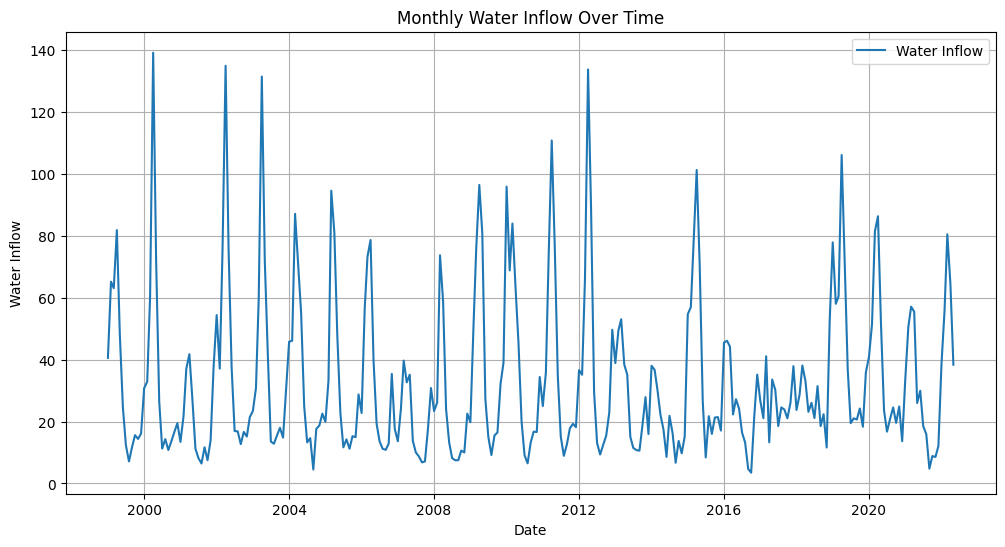

In [1207]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Value'], label='Water Inflow')
plt.title('Monthly Water Inflow Over Time')
plt.xlabel('Date')
plt.ylabel('Water Inflow')
plt.legend()
plt.grid()
plt.show()

In [1208]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Year     0
Month    0
Value    0
dtype: int64


In [1209]:
# Test for stationarity using Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = dict(zip(labels, result))
    for key, val in out.items():
        print(f"{key}: {val}")
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"\t{key}: {val}")
    if result[1] <= 0.05:
        print("Result: The data is stationary.")
    else:
        print("Result: The data is non-stationary.")

adf_test(data['Value'], title='Water Inflow')

Augmented Dickey-Fuller Test: Water Inflow
ADF Test Statistic: -3.75310193222027
p-value: 0.0034252875124864365
# Lags Used: 13
# Observations Used: 267
Critical Values:
	1%: -3.4550813975770827
	5%: -2.8724265892710914
	10%: -2.5725712007462582
Result: The data is stationary.


In [1210]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Preprocess + Feature Engineering

In [1211]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def create_future_prediction_dataset(df):
    # Sort dataframe chronologically
    df = df.sort_values(['Year', 'Month'])
    
    # Calculate yearly and monthly averages without future leakage
    yearly_means = df.groupby('Year')['Value'].mean()
    monthly_means = df.groupby('Month')['Value'].mean()
    
    # Add features based on historical averages
    df['Prev_Year_Mean'] = df['Year'].map(yearly_means.shift(1))
    #df['Month_Historical_Mean'] = df['Month'].map(monthly_means)
    
    # lags
    df['Lag1_Inflow_6'] = df['Value'].shift(6)
    df['Lag1_Inflow_12'] = df['Value'].shift(12)

    # Rolling window features
    # df['Rolling_6_Mean'] = df['Value'].rolling(window=6).mean().shift(5)
    # df['Rolling_12_Mean'] = df['Value'].rolling(window=12).mean().shift(5)
    # df['Rolling_6_Std'] = df['Value'].rolling(window=6).std().shift(5)
    # df['Rolling_12_Std'] = df['Value'].rolling(window=12).std().shift(5)

    # Cumulative mean for the current year until the current month
    # df['Cumulative_Mean'] = (
    #     df.groupby('Year')['Value']
    #     .expanding()
    #     .mean()
    #     .reset_index(level=0, drop=True)
    #     .shift(5)
    # )
    
    # Year-over-Year changes
    #df['YoY_Change'] = df['Value'].shift(1) - df['Value'].shift(13) # this seems to work well.
    #df['YoY_Percent_Change'] = (df['Value'].shift(6) - df['Value'].shift(18)) / df['Value'].shift(13)
    #df['YoY_Change'] = df['Value'].shift(1) - df['Value'].shift(14)
    #df['YoY_Percent_Change_2'] = (df['Value'].shift(2) - df['Value'].shift(13)) / df['Value'].shift(14)

    #df['Tw0_Year_Change'] = df['Value'].shift(6) - df['Value'].shift(18)  # Compare to two years ago
    #df['Three_Year_Change'] = df['Value'].shift(1) - df['Value'].shift(37)  # Compare to three years ago

    #df['Multi_Year_Percent_Change'] = (df['Value'].shift(1) - df['Value'].shift(25)) / df['Value'].shift(25)

    #df['Seasonal_Rolling_Mean'] = df['Value'].shift(5).rolling(window=6).mean()
    #df['Seasonal_Rolling_Std'] = df['Value'].shift(5).rolling(window=6).std()

    #df['Yearly_Cumulative'] = df.groupby('Year')['Value'].cumsum().shift(5)

    df['Short_vs_Long_Term'] = df['Value'].shift(5).rolling(window=3).mean() - df['Value'].shift(5).rolling(window=12).mean()
    #df['Short_vs_Long_Term_2'] = df['Value'].shift(5).rolling(window=3).mean() - df['Value'].shift(5).rolling(window=24).mean()

    # Lagged features with careful offset
    #df['Lag1_Inflow'] = df['Value'].shift(1)
    #df['Lag2_Inflow'] = df['Value'].shift(2)

    # df['Lagged_Diff_6'] = df['Value'].shift(6) - df['Value'].shift(12)
    # df['Lagged_Diff_12'] = df['Value'].shift(12) - df['Value'].shift(24)

    # monthly_means = df.groupby('Month')['Value'].transform('mean')
    # df['Seasonality_Index'] = df['Value'].shift(5) / monthly_means

    # df['Lag1_Smoothed'] = df['Value'].shift(5).ewm(span=6).mean()

    
    # Cyclical month encoding
    df['Month_Sin'] = np.sin(df['Month'] * (2 * np.pi / 12))
    df['Month_Cos'] = np.cos(df['Month'] * (2 * np.pi / 12))
    df['Year_Sin'] = np.sin(df['Year'] * (2 * np.pi / 12))
    df['Year_Cos'] = np.cos(df['Year'] * (2 * np.pi / 12))  
    
    # Remove rows with NaN to prevent leakage
    return df.dropna()

data = create_future_prediction_dataset(data)
data.head(30)

,Year,Month,Value,Prev_Year_Mean,Lag1_Inflow_6,Lag1_Inflow_12,Short_vs_Long_Term,Month_Sin,Month_Cos,Year_Sin,Year_Cos
date,,,,,,,,,,,
2000-05-01,2000,5,71.659560,33.390943,14.388636,48.081737,-18.012054,5.000000e-01,-8.660254e-01,-0.866025,-5.000000e-01
2000-06-01,2000,6,26.482899,33.390943,16.142621,24.487741,-12.134585,1.224647e-16,-1.000000e+00,-0.866025,-5.000000e-01
2000-07-01,2000,7,11.270656,33.390943,30.791891,12.416174,-3.275926,-5.000000e-01,-8.660254e-01,-0.866025,-5.000000e-01
2000-08-01,2000,8,14.326710,33.390943,32.892093,7.119303,11.703734,-8.660254e-01,-5.000000e-01,-0.866025,-5.000000e-01
2000-09-01,2000,9,10.812216,33.390943,60.412320,11.749033,43.049610,-1.000000e+00,-1.836970e-16,-0.866025,-5.000000e-01
2000-10-01,2000,10,13.596583,33.390943,139.154873,15.605411,54.007280,-8.660254e-01,5.000000e-01,-0.866025,-5.000000e-01
2000-11-01,2000,11,16.664829,33.390943,71.659560,14.388636,42.531209,-5.000000e-01,8.660254e-01,-0.866025,-5.000000e-01
2000-12-01,2000,12,19.475242,33.390943,26.482899,16.142621,-0.001403,-2.449294e-16,1.000000e+00,-0.866025,-5.000000e-01
2001-01-01,2001,1,13.427747,37.294989,11.270656,30.791891,-19.712970,5.000000e-01,8.660254e-01,-1.000000,-1.278835e-13


In [1212]:
data.drop(['Year', 'Month'], axis=1, inplace=True)

In [1213]:
# make train set as before 2020
YEAR = 2020
train = data[data.index.year < YEAR]
test = data[(data.index.year >= YEAR) & (data.index.month <= 5)]

In [1214]:
#data.drop(['Year', 'Month'], axis=1, inplace=True)

## Xgboost, catboost, random forest

In [1215]:
X_train, y_train = train.drop(columns=['Value']), train['Value']
X_test, y_test = test.drop(columns=['Value']), test['Value']

# Split into training and testing sets
# X = data.drop(columns=['Value'])
# y = data['Value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (236, 8)
Testing data shape: (15, 8)


In [1216]:
import optuna

def optimize_model(model_class, param_distributions, X_train, y_train, X_test, y_test, n_trials=50):
    """
    Generic function for hyperparameter optimization using Optuna.

    Parameters:
        model_class (class): The model class (e.g., XGBRegressor, CatBoostRegressor).
        param_distributions (dict): Dictionary of hyperparameters to optimize with Optuna.
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        X_valid (DataFrame): Validation features.
        y_valid (Series): Validation target.
        n_trials (int): Number of optimization trials (default is 50).

    Returns:
        dict: Best hyperparameters found by Optuna.
        float: Best RMSE score.
        object: Final model trained with the best hyperparameters.
    """
    def objective(trial):
        # Suggest hyperparameters
        params = {key: trial.suggest_categorical(key, values) if isinstance(values, list) else trial.suggest_float(key, *values, log=True)
                  if isinstance(values, tuple) else trial.suggest_int(key, *values)
                  for key, values in param_distributions.items()}

        # Create model instance with suggested parameters
        model = model_class(**params)

        # Train the model
        model.fit(X_train, y_train, verbose=0)

        # Predict and calculate RMSE
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))

        return rmse

    # Run the optimization
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    # Get best parameters and score
    best_params = study.best_params
    best_rmse = study.best_value

    # Train final model with best parameters
    final_model = model_class(**best_params)
    final_model.fit(X_train, y_train)

    return best_params, best_rmse, final_model

In [1217]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
rf_predictions = rf_model.predict(X_test)

# Evaluate performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)
print("****************************************")
feature_importances = rf_model.feature_importances_
features = X_train.columns
# sort
indices = np.argsort(feature_importances)

# print feature importances, dont plot
for i in indices:
    print(f"{features[i]}: {feature_importances[i]}")

Random Forest MAE: 13.664456302755218
Random Forest RMSE: 17.413600598357966
****************************************
Year_Sin: 0.05272762687184889
Year_Cos: 0.06601414962842751
Prev_Year_Mean: 0.0704908995943147
Short_vs_Long_Term: 0.07215222751805868
Month_Cos: 0.07427479924168325
Lag1_Inflow_6: 0.09270581648711591
Lag1_Inflow_12: 0.1163224771304983
Month_Sin: 0.4553120035280527


In [1218]:
# Define hyperparameter search space for XGBoost
xgb_params = {
    "n_estimators": (100, 1000),
    "learning_rate": (1e-3, 0.3),
    "max_depth": (3, 10),
    "min_child_weight": (1, 10),
    "gamma": (1e-7, 5),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "reg_alpha": (1e-7, 10),
    "reg_lambda": (1e-7, 10),
}

# Optimize XGBoost
best_xgb_params, best_xgb_rmse, xgb_model = optimize_model(XGBRegressor, xgb_params, X_train, y_train, X_test, y_test)
print("Best XGBoost Parameters:", best_xgb_params)
print("Best XGBoost RMSE:", best_xgb_rmse)

[I 2025-01-28 20:48:43,431] A new study created in memory with name: no-name-f0c6e4c9-5ae8-4051-a5b8-aad71afa8ac3
[W 2025-01-28 20:48:43,480] Trial 0 failed with parameters: {'n_estimators': 172.07737533629856, 'learning_rate': 0.052297409462468296, 'max_depth': 9.816141577695468, 'min_child_weight': 8.979981437281397, 'gamma': 1.5092562098875965e-07, 'subsample': 0.834418283657069, 'colsample_bytree': 0.9201165724501558, 'reg_alpha': 5.178572610320443e-05, 'reg_lambda': 0.6217417775564851} because of the following error: TypeError("'float' object cannot be interpreted as an integer").
Traceback (most recent call last):
  File "/Users/hamzagorgulu/Desktop/Self Improvement/Career/Job Applications/KoçDigital/Case/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_87022/4231993697.py", line 31, in objective
    model.fit(X_train, y_train, verbose=0)
  Fil

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate performance
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

print("XGBoost MAE:", xgb_mae)
print("XGBoost RMSE:", xgb_rmse)



XGBoost MAE: 19.910774391741857
XGBoost RMSE: 23.669399303503088
****************************************
Prev_Year_Mean: 0.011094371788203716
Short_vs_Long_Term: 0.01125501561909914
Lag1_Inflow_12: 0.013004900887608528
Lag1_Inflow_6: 0.013108773157000542
Year_Cos: 0.0336468406021595
Lag_5_Diff: 0.04056807607412338
Year_Sin: 0.04215194284915924
Lag_5_Value: 0.052910227328538895
Month_Cos: 0.2021506279706955
Month_Sin: 0.5801092386245728


In [1196]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 1, 10)
    gamma = trial.suggest_float("gamma", 0, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    # Create XGBoost Regressor with the suggested parameters
    xgb_model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
    )

    # Train and evaluate
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train final model with best hyperparameters
best_params = study.best_params
final_xgb_model = XGBRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    gamma=best_params["gamma"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    reg_alpha=best_params["reg_alpha"],
    reg_lambda=best_params["reg_lambda"],
    random_state=42,
)
final_xgb_model.fit(X_train, y_train)

# Predict and evaluate on test set
final_xgb_predictions = final_xgb_model.predict(X_test)
final_xgb_mae = mean_absolute_error(y_test, final_xgb_predictions)
final_xgb_rmse = np.sqrt(mean_squared_error(y_test, final_xgb_predictions))

print("Final XGBoost MAE:", final_xgb_mae)
print("Final XGBoost RMSE:", final_xgb_rmse)

# Feature importances
print("****************************************")
feature_importances = final_xgb_model.feature_importances_
features = X_train.columns
# Sort and print feature importances
indices = np.argsort(feature_importances)
for i in indices:
    print(f"{features[i]}: {feature_importances[i]}")


[I 2025-01-25 16:01:21,941] A new study created in memory with name: no-name-3462a3c8-bd85-44cb-aae4-b1f635cba006
[I 2025-01-25 16:01:22,787] Trial 0 finished with value: 18.643211364930895 and parameters: {'n_estimators': 912, 'learning_rate': 0.03385279568316996, 'max_depth': 9, 'min_child_weight': 5.549390833146783, 'gamma': 3.017028624915408, 'subsample': 0.6386563031367936, 'colsample_bytree': 0.5648285462790419, 'reg_alpha': 5.128185598360371, 'reg_lambda': 0.07079851322363329}. Best is trial 0 with value: 18.643211364930895.
[I 2025-01-25 16:01:23,513] Trial 1 finished with value: 17.965014476328307 and parameters: {'n_estimators': 864, 'learning_rate': 0.0024245044030581516, 'max_depth': 5, 'min_child_weight': 5.61293278497441, 'gamma': 0.3544406152899854, 'subsample': 0.8187714770961068, 'colsample_bytree': 0.9769061095259812, 'reg_alpha': 2.3344970160448817, 'reg_lambda': 3.972575915251716}. Best is trial 1 with value: 17.965014476328307.
[I 2025-01-25 16:01:24,007] Trial 2 f

Best hyperparameters: {'n_estimators': 954, 'learning_rate': 0.0028862943039717312, 'max_depth': 3, 'min_child_weight': 7.836963645671533, 'gamma': 3.945875530547595, 'subsample': 0.8756386238742144, 'colsample_bytree': 0.949746888465718, 'reg_alpha': 2.2143824046449887, 'reg_lambda': 0.4159749405260511}
Best RMSE: 15.286914175617818
Final XGBoost MAE: 11.686297130614259
Final XGBoost RMSE: 15.286914175617818
****************************************
Short_vs_Long_Term: 0.04174217954277992
Year_Sin: 0.04246898740530014
Prev_Year_Mean: 0.05602871999144554
Year_Cos: 0.05863131210207939
Lag1_Inflow_12: 0.06605904549360275
Lag_5_Diff: 0.06694304198026657
Lag1_Inflow_6: 0.07164672017097473
Lag_5_Value: 0.11291123926639557
Month_Cos: 0.11447686702013016
Month_Sin: 0.3690919578075409


In [ ]:

# Train CatBoost Regressor
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.05, random_state=42, verbose=0, depth=5, loss_function='RMSE')
cat_model.fit(X_train, y_train)

# Predict on test set
cat_predictions = cat_model.predict(X_test)

# Evaluate performance
cat_mae = mean_absolute_error(y_test, cat_predictions)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))

print("CatBoost MAE:", cat_mae)
print("CatBoost RMSE:", cat_rmse)

print("****************************************")
feature_importances = cat_model.feature_importances_
features = X_train.columns
# sort
indices = np.argsort(feature_importances)

# print feature importances, dont plot
for i in indices:
    print(f"{features[i]}: {feature_importances[i]}")


CatBoost MAE: 9.61265428861718
CatBoost RMSE: 13.273171795438408
****************************************
Short_vs_Long_Term: 3.8132684549273343
Year_Sin: 5.560566574136241
Lag_5_Diff: 5.679759590414192
Lag1_Inflow_6: 6.111922899007782
Prev_Year_Mean: 6.163327880744865
Year_Cos: 7.011185945773869
Lag_5_Value: 7.070639290335655
Lag1_Inflow_12: 8.529684514964579
Month_Cos: 15.470107887537656
Month_Sin: 34.58953696215783


In [1195]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    iterations = trial.suggest_int("iterations", 50, 1000)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.5, log=True)
    depth = trial.suggest_int("depth", 2, 15)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("random_strength", 1e-6, 10, log=True)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
    border_count = trial.suggest_int("border_count", 16, 255)

    # Create CatBoostRegressor with the suggested parameters
    cat_model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        random_state=42,
        verbose=0,
        loss_function="RMSE",
    )

    # Train and evaluate
    cat_model.fit(X_train, y_train)
    cat_predictions = cat_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))

    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train final model with best hyperparameters
best_params = study.best_params
final_model = CatBoostRegressor(
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    depth=best_params["depth"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    random_strength=best_params["random_strength"],
    bagging_temperature=best_params["bagging_temperature"],
    border_count=best_params["border_count"],
    random_state=42,
    verbose=0,
    loss_function="RMSE",
)
final_model.fit(X_train, y_train)

# Predict and evaluate on test set
final_predictions = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print("Final CatBoost MAE:", final_mae)
print("Final CatBoost RMSE:", final_rmse)

# Feature importances
print("****************************************")
feature_importances = final_model.feature_importances_
features = X_train.columns
# Sort and print feature importances
indices = np.argsort(feature_importances)
for i in indices:
    print(f"{features[i]}: {feature_importances[i]}")


[I 2025-01-25 15:56:54,338] A new study created in memory with name: no-name-c27966b5-474f-4602-8083-f7ae2e32c6bc
[I 2025-01-25 15:56:55,426] Trial 0 finished with value: 24.95280512406285 and parameters: {'iterations': 361, 'learning_rate': 0.0015157326030473877, 'depth': 12, 'l2_leaf_reg': 8.259019647734487, 'random_strength': 1.1673767872177552, 'bagging_temperature': 0.32865162768346357, 'border_count': 55}. Best is trial 0 with value: 24.95280512406285.
[I 2025-01-25 15:57:00,379] Trial 1 finished with value: 18.152531894369353 and parameters: {'iterations': 268, 'learning_rate': 0.4966679302203079, 'depth': 13, 'l2_leaf_reg': 4.7288342575459685, 'random_strength': 0.07559703750627197, 'bagging_temperature': 0.7924114288022724, 'border_count': 171}. Best is trial 1 with value: 18.152531894369353.
[I 2025-01-25 15:57:03,596] Trial 2 finished with value: 16.626287534528213 and parameters: {'iterations': 899, 'learning_rate': 0.135145265479306, 'depth': 10, 'l2_leaf_reg': 9.972647592

Best hyperparameters: {'iterations': 427, 'learning_rate': 0.014327031422447139, 'depth': 2, 'l2_leaf_reg': 7.7827725646542865, 'random_strength': 4.593466934786595e-06, 'bagging_temperature': 0.7983658316812099, 'border_count': 204}
Best RMSE: 12.034640425267531
Final CatBoost MAE: 8.359211533643812
Final CatBoost RMSE: 12.034640425267531
****************************************
Lag_5_Diff: 1.3817969633097187
Year_Sin: 1.393034101204138
Lag1_Inflow_6: 1.8752678665043718
Year_Cos: 1.9094926713284643
Short_vs_Long_Term: 2.6224264808205136
Prev_Year_Mean: 3.0850177520079
Lag_5_Value: 5.773421510083234
Lag1_Inflow_12: 7.2032500518005005
Month_Cos: 9.130711468012374
Month_Sin: 65.6255811349288


In [1192]:
y_test.index = y_test.index.strftime('%Y-%m-%d')

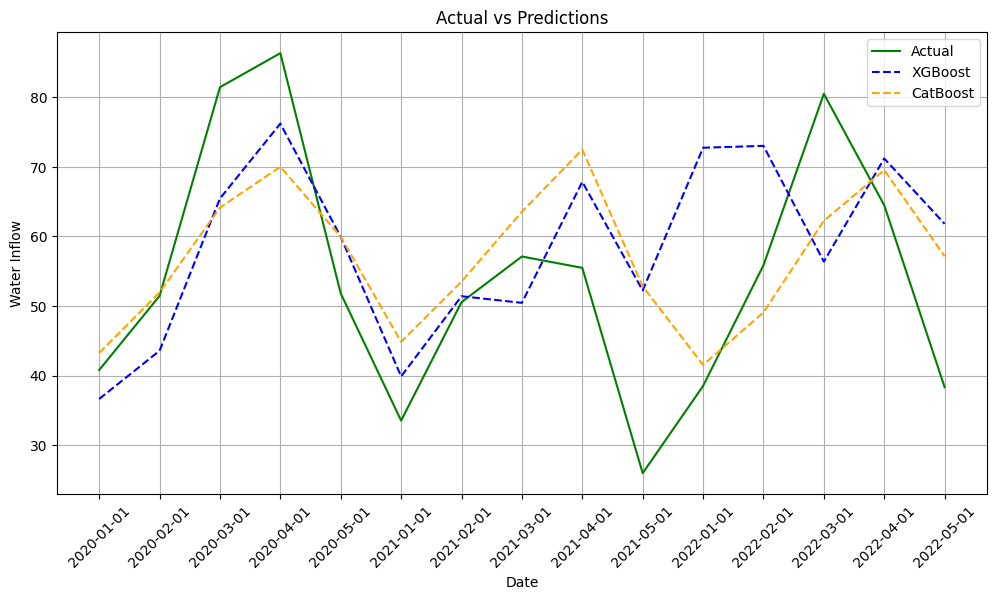

In [878]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='green')
#plt.plot(y_test.index, rf_predictions, label='Random Forest', linestyle='--', color='red')
plt.plot(y_test.index, xgb_predictions, label='XGBoost', linestyle='--', color='blue')
plt.plot(y_test.index, cat_predictions, label='CatBoost', linestyle='--', color='orange')
plt.title('Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Water Inflow')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## LSTM

In [ ]:
data = pd.read_csv('../data/multistep_regression.csv')
data.head()

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['inflow_scaled'] = scaler.fit_transform(data[['Value']])

# Create sequences for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_column, seq_length):
        self.data = data
        self.target_column = target_column
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data.iloc[index:index + self.seq_length][self.target_column].values
        y = self.data.iloc[index + self.seq_length][self.target_column]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create dataset
seq_length = 12
dataset = TimeSeriesDataset(data, target_column='inflow_scaled', seq_length=seq_length)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print("Train size:", train_size)
print("Test size:", test_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train size: 215
Test size: 54


In [31]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

# Initialize model
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(model)



LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.unsqueeze(-1)  # Add feature dimension
        y_batch = y_batch.unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")



Epoch 1/50, Loss: 0.0665
Epoch 2/50, Loss: 0.0393
Epoch 3/50, Loss: 0.0399
Epoch 4/50, Loss: 0.0377
Epoch 5/50, Loss: 0.0379
Epoch 6/50, Loss: 0.0374
Epoch 7/50, Loss: 0.0369
Epoch 8/50, Loss: 0.0368
Epoch 9/50, Loss: 0.0368
Epoch 10/50, Loss: 0.0366
Epoch 11/50, Loss: 0.0359
Epoch 12/50, Loss: 0.0362
Epoch 13/50, Loss: 0.0362
Epoch 14/50, Loss: 0.0355
Epoch 15/50, Loss: 0.0349
Epoch 16/50, Loss: 0.0345
Epoch 17/50, Loss: 0.0332
Epoch 18/50, Loss: 0.0314
Epoch 19/50, Loss: 0.0291
Epoch 20/50, Loss: 0.0248
Epoch 21/50, Loss: 0.0232
Epoch 22/50, Loss: 0.0211
Epoch 23/50, Loss: 0.0196
Epoch 24/50, Loss: 0.0187
Epoch 25/50, Loss: 0.0189
Epoch 26/50, Loss: 0.0178
Epoch 27/50, Loss: 0.0178
Epoch 28/50, Loss: 0.0169
Epoch 29/50, Loss: 0.0173
Epoch 30/50, Loss: 0.0168
Epoch 31/50, Loss: 0.0164
Epoch 32/50, Loss: 0.0159
Epoch 33/50, Loss: 0.0164
Epoch 34/50, Loss: 0.0159
Epoch 35/50, Loss: 0.0169
Epoch 36/50, Loss: 0.0166
Epoch 37/50, Loss: 0.0165
Epoch 38/50, Loss: 0.0156
Epoch 39/50, Loss: 0.

In [ ]:
# Evaluate on the test set
model.eval()
y_test_actual = []
y_test_predicted = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.unsqueeze(-1)
        y_batch = y_batch.unsqueeze(-1)

        predictions = model(x_batch)
        y_test_actual.extend(y_batch.numpy())
        y_test_predicted.extend(predictions.numpy())

# Rescale the predictions back to original values
y_test_actual_rescaled = scaler.inverse_transform(np.array(y_test_actual).reshape(-1, 1))
y_test_predicted_rescaled = scaler.inverse_transform(np.array(y_test_predicted).reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual_rescaled, y_test_predicted_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_predicted_rescaled))

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Forecast the next 5 months
model.eval()
last_sequence = torch.tensor(data['inflow_scaled'].values[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

future_predictions = []
for _ in range(5):
    with torch.no_grad():
        next_prediction = model(last_sequence).item()
        future_predictions.append(next_prediction)

        # Update the sequence with the predicted value
        last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor([[next_prediction]], dtype=torch.float32).unsqueeze(-1)), dim=1)

# Rescale future predictions back to original values
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("\nForecast for the Next 5 Months:")
print(future_predictions_rescaled.flatten())



Model Evaluation Metrics:
Mean Absolute Error (MAE): 9.65
Root Mean Squared Error (RMSE): 12.95

Forecast for the Next 5 Months:
[28.13312845 10.99142754  9.03666657 10.49786048 13.59888884]


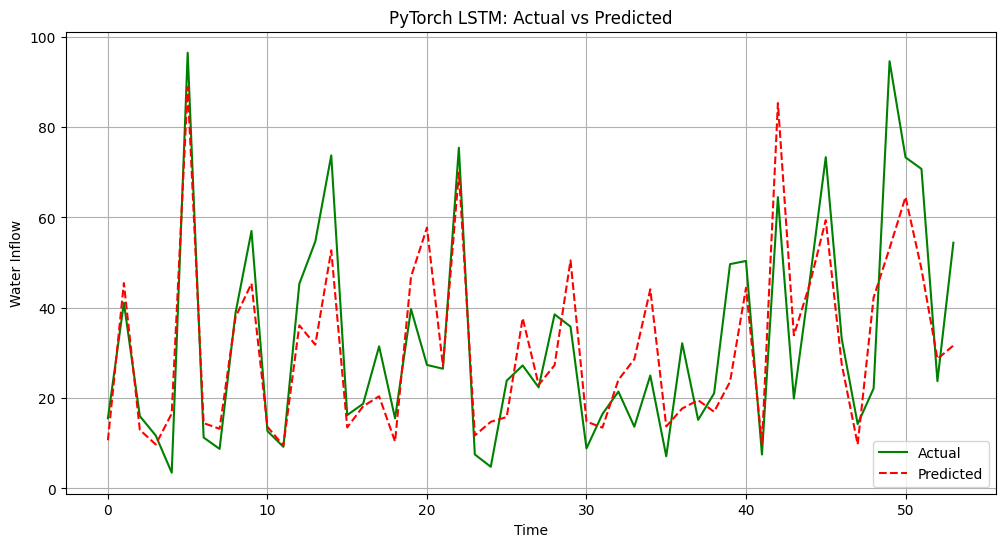

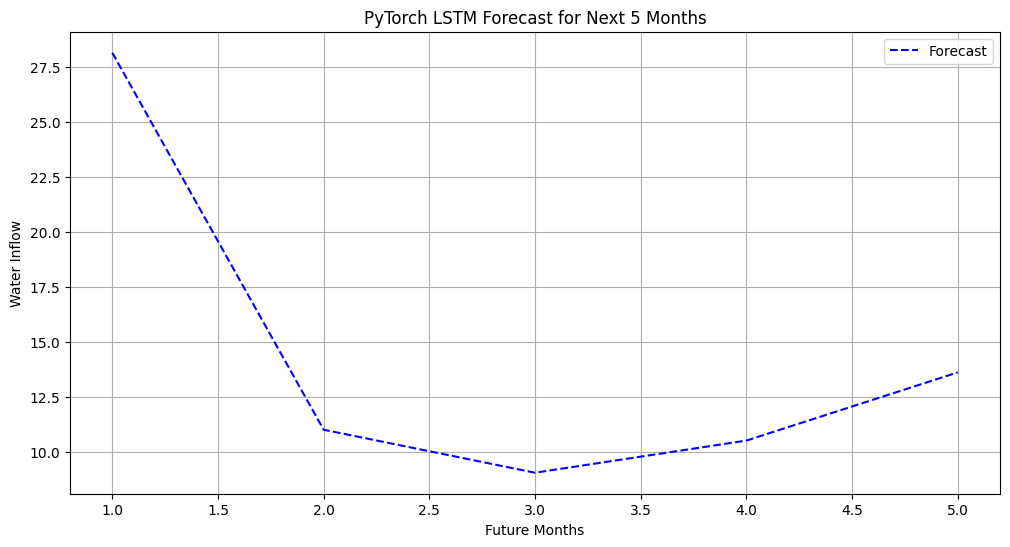

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted on the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Actual', color='green')
plt.plot(y_test_predicted_rescaled, label='Predicted', color='red', linestyle='--')
plt.title('PyTorch LSTM: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Water Inflow')
plt.legend()
plt.grid()
plt.show()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), future_predictions_rescaled, label='Forecast', color='blue', linestyle='--')
plt.title('PyTorch LSTM Forecast for Next 5 Months')
plt.xlabel('Future Months')
plt.ylabel('Water Inflow')
plt.legend()
plt.grid()
plt.show()
